In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SEQ_LENGTH = 30

In [ ]:
df = pd.read_csv("./data/weather_data_72493023230_OAK_10-22.csv", parse_dates=["DATE"])

# Set DATE as index
df.index = df["DATE"]

# Keep only selected columns
keep_columns = ['DATE', 'TEMP', 'DEWP', 'SLP', 'STP', 'WDSP', 'MAX', 'MIN', 'PRCP', 'LATITUDE', 'LONGITUDE']
df = df[keep_columns]

# Split by date ranges
df_train = df["2010-01-01":"2020-12-31"].copy()
df_valid = df["2021-01-01":"2021-12-31"].copy()
df_test = df["2022-01-01":"2022-12-31"].copy()

for split_df in [df_train, df_valid, df_test]:
    split_df['YEAR'] = split_df['DATE'].dt.year
    split_df['MONTH'] = split_df['DATE'].dt.month
    split_df['DAY'] = split_df['DATE'].dt.day
    split_df.drop(columns=['DATE'], inplace=True)

In [ ]:
df_train.head()

,TEMP,DEWP,SLP,STP,WDSP,MAX,MIN,PRCP,LATITUDE,LONGITUDE,YEAR,MONTH,DAY
DATE,,,,,,,,,,,,,
2010-01-01,52.9,46.7,1027.2,23.9,2.4,61.0,48.9,0.0,37.7178,-122.23301,2010,1,1
2010-01-02,54.6,51.6,1025.2,22.0,2.6,57.0,51.8,0.0,37.7178,-122.23301,2010,1,2
2010-01-03,49.2,45.0,1022.2,19.0,3.1,57.0,41.0,0.0,37.7178,-122.23301,2010,1,3
2010-01-04,48.1,42.5,1021.1,18.0,6.8,57.0,43.0,0.0,37.7178,-122.23301,2010,1,4
2010-01-05,47.6,43.0,1021.7,18.6,3.9,55.0,39.9,0.0,37.7178,-122.23301,2010,1,5


In [ ]:
df_train.dtypes

,0
TEMP,float64
DEWP,float64
SLP,float64
STP,float64
WDSP,float64
MAX,float64
MIN,float64
PRCP,float64
LATITUDE,float64
LONGITUDE,float64


In [ ]:
df_train.columns

Index(['TEMP', 'DEWP', 'SLP', 'STP', 'WDSP', 'MAX', 'MIN', 'PRCP', 'LATITUDE',
       'LONGITUDE', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')

In [ ]:
def create_sequences(data: pd.DataFrame, seq_length, include_all_features=False):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
      if include_all_features:
        x = data.iloc[i:i+seq_length]
      else:
        x = data.iloc[i:i+seq_length]["TEMP"]
      y = data.iloc[i+seq_length]["TEMP"]
      xs.append(x)
      ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):

        if X.shape[-1]==SEQ_LENGTH:
            self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        else:
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
X_train, y_train = create_sequences(df_train, SEQ_LENGTH)

mean = X_train.mean(axis=(0, 1), keepdims=True)  # mean per feature
std = X_train.std(axis=(0, 1), keepdims=True)
y_mean = y_train.mean(axis=0, keepdims=True)
y_std = y_train.std(axis=0, keepdims=True)

X_train_norm = (X_train - mean) / std
y_train_norm = (y_train - y_mean) / y_std

X_val, y_val = create_sequences(df_valid, SEQ_LENGTH)
X_val_norm = (X_val-mean) / std
y_val_norm = (y_val-y_mean) / y_std

train_dataset = TimeSeriesDataset(X_train_norm, y_train_norm)
val_dataset = TimeSeriesDataset(X_val_norm, y_val_norm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


X_test, y_test = create_sequences(df_test, SEQ_LENGTH)
X_test_norm = (X_test - mean) / std
y_test_norm = (y_test - y_mean) / y_std

dataset_test = TimeSeriesDataset(X_test_norm, y_test_norm)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
print(X_train_norm[0])
print(y_train_norm[0])

[-0.86673922 -0.59782483 -1.45202349 -1.62602693 -1.7051194  -1.7051194
 -1.80003036 -1.53111596 -1.87912283 -2.16385572 -1.57857145 -0.70855429
 -0.29727345 -1.48366048 -1.37293103 -1.29383856 -0.78764676 -0.77182826
 -0.97746868 -1.10401663 -1.67348241 -2.13221873 -1.73675638 -1.76839337
 -1.02492416 -0.86673922 -1.49947898 -1.27802006 -1.21474609 -1.13565362]
-1.5667440713143082


In [ ]:
def train_model_with_val(model, train_loader, val_loader, optimizer, loss_fn, device):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # print(X_batch.shape)

        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(f"outputs {outputs.shape}")
        # print(f"labels {y_batch.shape}")
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)


    model.eval()
    running_val_loss = 0.0
    # print("about to eval")
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            # print(f"val {y_batch.shape}")
            # print(f"out {outputs.shape}")
            loss = loss_fn(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)


    return running_train_loss / len(train_loader.dataset), running_val_loss / len(val_loader.dataset)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def test_model(model, test_loader, std, mean, title):
    test_predictions = np.empty((0, 1))
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            predictions = model(x_batch)
            predictions_np = predictions.view(-1).numpy()

            test_predictions = np.append(test_predictions, predictions_np)

    test_predictions = test_predictions * std + mean

    print(mean_squared_error(df_test[SEQ_LENGTH:]["TEMP"], test_predictions))
    print(mean_absolute_error(df_test[SEQ_LENGTH:]["TEMP"], test_predictions))

    fig, ax = plt.subplots()

    ax.plot(df_test.index, df_test["TEMP"], label="actual")
    ax.plot(df_test.index[SEQ_LENGTH:], test_predictions, label="predicted")
    ax.legend()
    ax.set_title(title)

In [ ]:
def display_train_val_loss(epoch_losses, val_losses, title):
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
class NaiveModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # print(x.shape)
        # print(x)
        # return
        out = x[:, -1]
        return out

7.47297332204337
2.0779778142658016


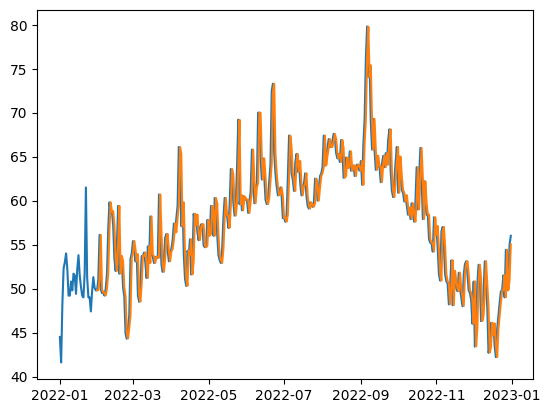

In [ ]:
naive_model = NaiveModel()
naive_predictions = naive_model(X_test)
naive_predictions.shape

test_model(naive_model, dataloader_test, y_std, y_mean, "LSTM 1 var")

In [3]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2, output_dim=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        # print(x.shape)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        # print(out.shape)
        out = self.relu(self.linear1(out))
        return self.linear2(out)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

EPOCHS = 20
epoch_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss, val_loss = train_model_with_val(model, train_loader, val_loader, optimizer, loss_fn, device)
    epoch_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.7390, Val Loss: 0.2435
Epoch 2/20, Train Loss: 0.3637, Val Loss: 0.2175
Epoch 3/20, Train Loss: 0.3399, Val Loss: 0.2044
Epoch 4/20, Train Loss: 0.3232, Val Loss: 0.1930
Epoch 5/20, Train Loss: 0.3059, Val Loss: 0.1845
Epoch 6/20, Train Loss: 0.2881, Val Loss: 0.1727
Epoch 7/20, Train Loss: 0.2625, Val Loss: 0.1645
Epoch 8/20, Train Loss: 0.2404, Val Loss: 0.1510
Epoch 9/20, Train Loss: 0.2196, Val Loss: 0.1418
Epoch 10/20, Train Loss: 0.2002, Val Loss: 0.1462
Epoch 11/20, Train Loss: 0.1941, Val Loss: 0.1305
Epoch 12/20, Train Loss: 0.1848, Val Loss: 0.1328
Epoch 13/20, Train Loss: 0.1830, Val Loss: 0.1252
Epoch 14/20, Train Loss: 0.1807, Val Loss: 0.1291
Epoch 15/20, Train Loss: 0.1813, Val Loss: 0.1260
Epoch 16/20, Train Loss: 0.1803, Val Loss: 0.1256
Epoch 17/20, Train Loss: 0.1777, Val Loss: 0.1263
Epoch 18/20, Train Loss: 0.1793, Val Loss: 0.1331
Epoch 19/20, Train Loss: 0.1799, Val Loss: 0.1276
Epoch 20/20, Train Loss: 0.1781, Val Loss: 0.1240


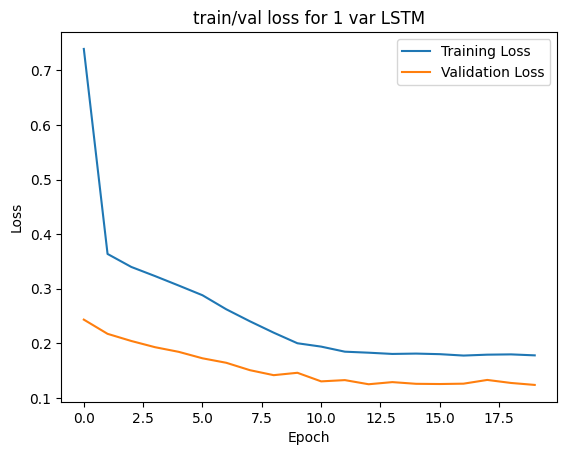

In [ ]:
display_train_val_loss(epoch_losses, val_losses, "train/val loss for 1 var LSTM")

6.684417790220713
1.9838392004376546


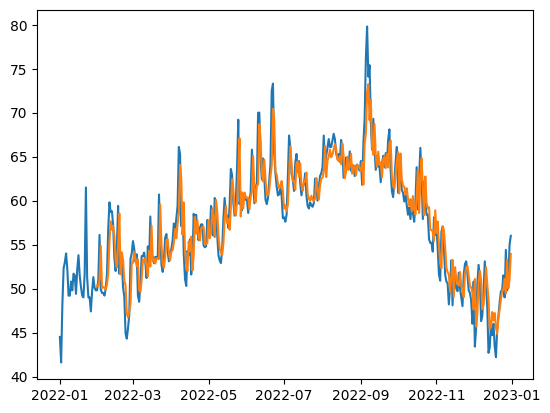

In [ ]:
test_model(model, dataloader_test, y_std, y_mean)

In [7]:
class CNN_LSTM(torch.nn.Module):
    def __init__(self, seq_len=30, dim=1):
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.conv1 = torch.nn.Conv1d(in_channels=dim, out_channels=256, kernel_size=2)
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size=2)
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten = torch.nn.Flatten()
        self.recursive1 = torch.nn.LSTM(32, 128)
        self.lstm1 = torch.nn.LSTM(input_size=1792, hidden_size=100, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.lstm2 = torch.nn.LSTM(input_size=100, hidden_size=100, batch_first=True)
        self.lstm3 = torch.nn.LSTM(input_size=100, hidden_size=100, batch_first=True)
        self.bilstm = torch.nn.LSTM(input_size=100, hidden_size=128, batch_first=True, bidirectional=True)  # 128*2=256
        self.fc1 = torch.nn.Linear(seq_len*256, 100)
        self.fc2 = torch.nn.Linear(100, 1)

    def forward(self, x: torch.Tensor):
        # x: (batch, 30, 1)
        x = x.permute(0, 2, 1)  # (batch, 1, 30)
        x = self.conv1(x)       # -> (batch, 256, 29)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv2(x)       # -> (batch, 128, 28)
        x = torch.nn.functional.leaky_relu(x)
        x = self.pool(x)        # -> (batch, 128, 14)
        x = x.permute(0, 2, 1)  # -> (batch, 14, 128)
        x = self.flatten(x)     # -> (batch, 1792)

        # RepeatVector: expand to (batch, 30, 1792)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)

        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.bilstm(x)

        #not sure if correct should flatten to (batch, 30*out bilem)
        x = self.flatten(x)

        x = self.fc1(x)  # (batch, 100)
        x = torch.nn.functional.leaky_relu(x)
        x = self.fc2(x)  # (batch, 30, 1)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

EPOCHS = 10
epoch_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss, val_loss = train_model_with_val(model, train_loader, val_loader, optimizer, loss_fn, device)
    epoch_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 0.4391, Val Loss: 0.1884
Epoch 2/10, Train Loss: 0.2468, Val Loss: 0.1662
Epoch 3/10, Train Loss: 0.2131, Val Loss: 0.1580
Epoch 4/10, Train Loss: 0.2049, Val Loss: 0.1609
Epoch 5/10, Train Loss: 0.1861, Val Loss: 0.1554
Epoch 6/10, Train Loss: 0.1820, Val Loss: 0.1648
Epoch 7/10, Train Loss: 0.1756, Val Loss: 0.1886
Epoch 8/10, Train Loss: 0.1712, Val Loss: 0.1479
Epoch 9/10, Train Loss: 0.1668, Val Loss: 0.1620
Epoch 10/10, Train Loss: 0.1618, Val Loss: 0.1506


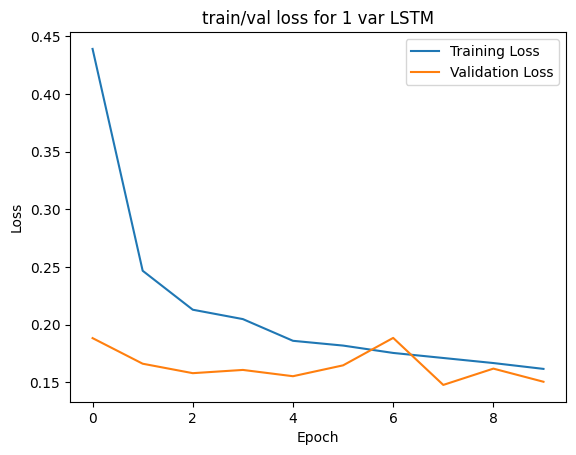

In [ ]:
display_train_val_loss(epoch_losses, val_losses, "train/val loss for 1 var CNN-LSTM")

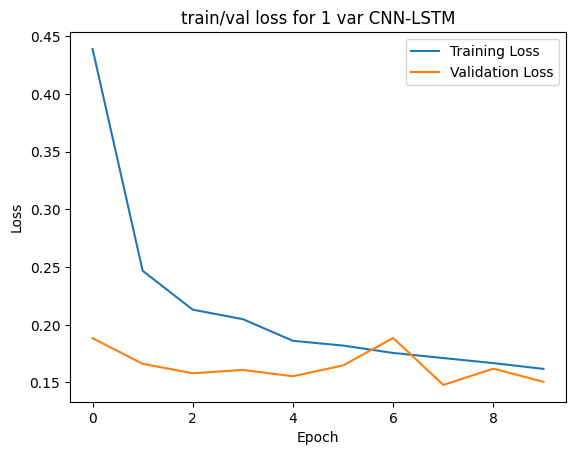

In [ ]:
display_train_val_loss([0.4391,0.2468,0.2131,0.2049,0.1861,0.1820,.1756,0.1712,0.1668,0.1618], [0.1884, 0.1662, 0.1580, 0.1609, 0.1554, 0.1648, 0.1886, 0.1479, 0.1620, 0.1506], "train/val loss for 1 var CNN-LSTM")

7.261410826543381
2.044811659099291


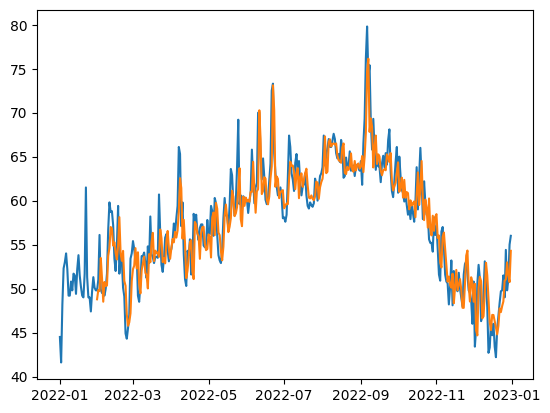

In [ ]:
test_model(model, dataloader_test, y_std, y_mean, "CNN-LSTM 1 Var")

Decomposition

In [ ]:
SEQ_LENGTH = 40
BATCH_SIZE = 32
EPOCHS = 20
LEARN_RATE = 0.0001

In [ ]:
from statsmodels.tsa.seasonal import STL

def rolling_stl(series, period, window_length):
    trend = []
    seasonal = []
    resid = []

    for t in range(window_length - 1, len(series)):
        window_data = series[t - window_length + 1 : t + 1]
        stl = STL(window_data, period=period, robust=True)
        result = stl.fit()

        # Append only the **last** values (current time t)
        trend.append(result.trend[-1])
        seasonal.append(result.seasonal[-1])
        resid.append(result.resid[-1])

    # Pad the beginning to match length
    pad_len = window_length - 1
    trend = [np.nan] * pad_len + trend
    seasonal = [np.nan] * pad_len + seasonal
    resid = [np.nan] * pad_len + resid

    return np.array(trend), np.array(seasonal), np.array(resid)

# Example usage
window_length = 24  # should be >= period, pick based on your data
period = 12

trend_train, seasonal_train, residual_train = rolling_stl(df_train["TEMP"].values, period, window_length)
trend_valid, seasonal_valid, residual_valid = rolling_stl(df_valid["TEMP"].values, period, window_length)
trend_test, seasonal_test, residual_test = rolling_stl(df_test["TEMP"].values, period, window_length)


# remove nan padding
train_nan_idx = ~np.isnan(trend_train)
trend_train = trend_train[train_nan_idx]
seasonal_train = seasonal_train[train_nan_idx]
residual_train = residual_train[train_nan_idx]
original_train = df_train["TEMP"].values[train_nan_idx]

valid_nan_idx = ~np.isnan(trend_valid)
trend_valid = trend_valid[valid_nan_idx]
seasonal_valid = seasonal_valid[valid_nan_idx]
residual_valid = residual_valid[valid_nan_idx]
original_valid = df_valid["TEMP"].values[valid_nan_idx]

test_nan_idx = ~np.isnan(trend_test)
trend_test = trend_test[test_nan_idx]
seasonal_test = seasonal_test[test_nan_idx]
residual_test = residual_test[test_nan_idx]
original_test = df_test["TEMP"].values[test_nan_idx]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_trend = StandardScaler()
scaler_seasonal = StandardScaler()
scaler_residual = StandardScaler()
scaler_original = StandardScaler()

# Fit on TRAINING data only
scaler_trend.fit(trend_train.reshape(-1, 1))
scaler_seasonal.fit(seasonal_train.reshape(-1, 1))
scaler_residual.fit(residual_train.reshape(-1, 1))
scaler_original.fit(df_train["TEMP"].values.reshape(-1, 1))  # Still a pandas Series for df_train

# Transform train/val/test
trend_train_norm = scaler_trend.transform(trend_train.reshape(-1, 1))
trend_val_norm = scaler_trend.transform(trend_valid.reshape(-1, 1))
trend_test_norm = scaler_trend.transform(trend_test.reshape(-1, 1))

seasonal_train_norm = scaler_seasonal.transform(seasonal_train.reshape(-1, 1))
seasonal_val_norm = scaler_seasonal.transform(seasonal_valid.reshape(-1, 1))
seasonal_test_norm = scaler_seasonal.transform(seasonal_test.reshape(-1, 1))

residual_train_norm = scaler_residual.transform(residual_train.reshape(-1, 1))
residual_val_norm = scaler_residual.transform(residual_valid.reshape(-1, 1))
residual_test_norm = scaler_residual.transform(residual_test.reshape(-1, 1))

original_train_norm = scaler_original.transform(df_train["TEMP"].values.reshape(-1, 1))
original_val_norm = scaler_original.transform(df_valid["TEMP"].values.reshape(-1, 1))
original_test_norm = scaler_original.transform(df_test["TEMP"].values.reshape(-1, 1))

In [ ]:
def create_sequences_decomp(trend, seasonal, residual, original, target, seq_length):
    X, y = [], []
    num_samples = len(trend) - seq_length
    for i in range(num_samples):
        seq = np.hstack((
            trend[i:i+seq_length],
            seasonal[i:i+seq_length],
            residual[i:i+seq_length],
            original[i:i+seq_length]
        ))  # shape (seq_length, 4)
        X.append(seq)

        target_val = target[i + seq_length]  # predict temp at t+seq_length
        y.append(target_val)

    X = np.stack(X)  # shape (num_samples, seq_length, 4)
    y = np.stack(y)  # shape (num_samples, 1)
    return X, y

In [ ]:
X_train, y_train = create_sequences_decomp(trend_train_norm, seasonal_train_norm, residual_train_norm,
                                    original_train_norm, original_train_norm, SEQ_LENGTH)

X_val, y_val = create_sequences_decomp(trend_val_norm, seasonal_val_norm, residual_val_norm,
                                original_val_norm, original_val_norm, SEQ_LENGTH)

X_test, y_test = create_sequences_decomp(trend_test_norm, seasonal_test_norm, residual_test_norm,
                                  original_test_norm, original_test_norm, SEQ_LENGTH)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class DecompDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = DecompDataset(X_train, y_train)
val_dataset = DecompDataset(X_val, y_val)
test_dataset = DecompDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BLSM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BLSM, self).__init__()

        # Bi-LSTM for each decomposed component (trend, seasonal, residual)
        self.lstm_trend = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                                  batch_first=True, bidirectional=True, dropout=0.2)
        self.fc_trend = nn.Linear(hidden_size * 2, 1)

        self.lstm_seasonal = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                                     batch_first=True, bidirectional=True, dropout=0.2)
        self.fc_seasonal = nn.Linear(hidden_size * 2, 1)

        self.lstm_residual = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                                     batch_first=True, bidirectional=True, dropout=0.2)
        self.fc_residual = nn.Linear(hidden_size * 2, 1)

        # Bi-LSTM for original series
        self.lstm_original = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                                     batch_first=True, bidirectional=True, dropout=0.2)
        self.fc_original = nn.Linear(hidden_size * 2, 1)

        # Final fusion layer
        self.fc_fusion = nn.Linear(2, 1)  # combining [pred1, pred2] → final prediction

    def forward(self, x):
        # print(x.shape)
        trend = x[:, :, 0].unsqueeze(-1)
        # print(trend.shape)
        seasonal = x[:, :, 1].unsqueeze(-1)
        residual = x[:, :, 2].unsqueeze(-1)
        original = x[:, :, 3].unsqueeze(-1)
        # trend path
        trend_output, _ = self.lstm_trend(trend)
        trend_last = trend_output[:, -1, :]  # take last timestep output
        pred_trend = self.fc_trend(trend_last)

        # seasonal path
        seasonal_output, _ = self.lstm_seasonal(seasonal)
        seasonal_last = seasonal_output[:, -1, :]
        pred_seasonal = self.fc_seasonal(seasonal_last)

        # residual path
        residual_output, _ = self.lstm_residual(residual)
        residual_last = residual_output[:, -1, :]
        pred_residual = self.fc_residual(residual_last)

        # sum decomposed predictions → first predicted value
        pred1 = pred_trend + pred_seasonal + pred_residual

        # original path
        original_output, _ = self.lstm_original(original)
        original_last = original_output[:, -1, :]
        pred2 = self.fc_original(original_last)

        # combine pred1 and pred2 → final prediction
        combined = torch.cat([pred1, pred2], dim=1)
        final_pred = self.fc_fusion(combined)

        return final_pred

In [ ]:
def test_model_decomp(model, test_loader, std=None, mean=None, scale_transformer:StandardScaler=None, title=None):
    start_test_preds = df_test.shape[0] - len(test_loader.dataset)
    test_predictions = np.empty((0, 1))
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            predictions = model(x_batch)
            predictions_np = predictions.view(-1).numpy()

            test_predictions = np.append(test_predictions, predictions_np)

    # print("BEFORE")
    # print(type(test_predictions))
    print(test_predictions.shape)

    # print("AFTER")

    if not mean==None and not std==None:
        test_predictions = test_predictions * std + mean
    elif not scale_transformer==None:
        test_predictions = scale_transformer.inverse_transform(test_predictions.reshape(-1, 1))
        # print(type(test_predictions))
        print(test_predictions.shape)
        print(df_test[start_test_preds:].shape)


    print(mean_squared_error(df_test[start_test_preds:]["TEMP"], test_predictions))
    print(mean_absolute_error(df_test[start_test_preds:]["TEMP"], test_predictions))

    fig, ax = plt.subplots()

    ax.plot(df_test["DATE"], df_test["TEMP"])
    ax.plot(df_test[start_test_preds:]["DATE"], test_predictions)
    if not title==None:
        ax.set_title(title)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BLSM()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    train_loss, val_loss = train_model_with_val(model, train_loader, val_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.8830, Val Loss: 0.2281
Epoch 2/20, Train Loss: 0.3421, Val Loss: 0.1749
Epoch 3/20, Train Loss: 0.2771, Val Loss: 0.1498
Epoch 4/20, Train Loss: 0.2445, Val Loss: 0.1333
Epoch 5/20, Train Loss: 0.2057, Val Loss: 0.1176
Epoch 6/20, Train Loss: 0.1825, Val Loss: 0.1154
Epoch 7/20, Train Loss: 0.1752, Val Loss: 0.1132
Epoch 8/20, Train Loss: 0.1688, Val Loss: 0.1098
Epoch 9/20, Train Loss: 0.1633, Val Loss: 0.1070
Epoch 10/20, Train Loss: 0.1580, Val Loss: 0.1058
Epoch 11/20, Train Loss: 0.1522, Val Loss: 0.0980
Epoch 12/20, Train Loss: 0.1481, Val Loss: 0.0960
Epoch 13/20, Train Loss: 0.1393, Val Loss: 0.0880
Epoch 14/20, Train Loss: 0.1331, Val Loss: 0.0845
Epoch 15/20, Train Loss: 0.1315, Val Loss: 0.0906
Epoch 16/20, Train Loss: 0.1280, Val Loss: 0.0839
Epoch 17/20, Train Loss: 0.1252, Val Loss: 0.0816
Epoch 18/20, Train Loss: 0.1229, Val Loss: 0.0811
Epoch 19/20, Train Loss: 0.1213, Val Loss: 0.0797
Epoch 20/20, Train Loss: 0.1185, Val Loss: 0.0766


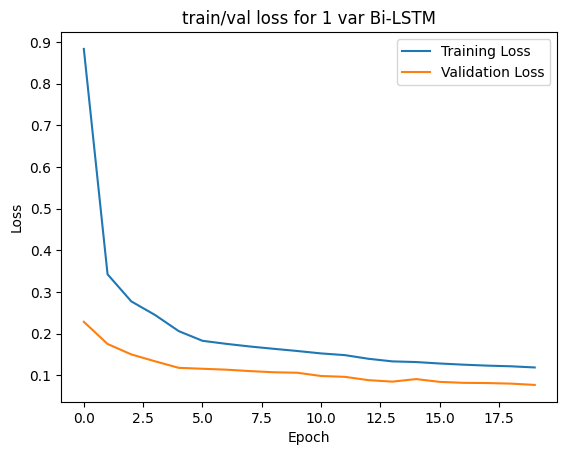

In [ ]:
display_train_val_loss([0.8830, 0.3421, 0.2771, 0.2445, 0.2057, 0.1825, 0.1752, 0.1688, 0.1633, 0.1580, 0.1522, 0.1481, 0.1393, 0.1331, 0.1315, 0.1280, 0.1252, 0.1229, 0.1213, 0.1185],[0.2281, 0.1749, 0.1498, 0.1333, 0.1176, 0.1154, 0.1132, 0.1098, 0.1070, 0.1058, 0.0980, 0.0960, 0.0880, 0.0845, 0.0906, 0.0839, 0.0816, 0.0811, 0.0797, 0.0766],"train/val loss for 1 var Bi-LSTM")

(302,)
(302, 1)
(302, 28)
25.42991935835559
3.991531143825


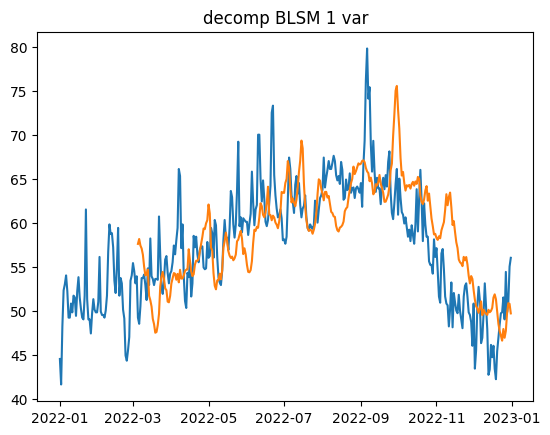

In [ ]:
test_model_decomp(model, test_loader, scale_transformer=scaler_original, title="decomp BLSM 1 var")

# Includ all features

In [ ]:
SEQ_LENGTH = 30

In [ ]:
X_train, y_train = create_sequences(df_train, SEQ_LENGTH, include_all_features=True)

mean = X_train.mean(axis=(0, 1), keepdims=True)  # mean per feature
std = X_train.std(axis=(0, 1), keepdims=True)
y_mean = y_train.mean(axis=0, keepdims=True)
y_std = y_train.std(axis=0, keepdims=True)

X_train_norm = (X_train - mean) / std
y_train_norm = (y_train - y_mean) / y_std

X_val, y_val = create_sequences(df_valid, SEQ_LENGTH, include_all_features=True)
X_val_norm = (X_val-mean) / std
y_val_norm = (y_val-y_mean) / y_std

train_dataset = TimeSeriesDataset(X_train_norm, y_train_norm)
val_dataset = TimeSeriesDataset(X_val_norm, y_val_norm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


X_test, y_test = create_sequences(df_test, SEQ_LENGTH, include_all_features=True)
X_test_norm = (X_test - mean) / std
y_test_norm = (y_test - y_mean) / y_std

dataset_test = TimeSeriesDataset(X_test_norm, y_test_norm)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
df_train.columns

Index(['TEMP', 'DEWP', 'SLP', 'STP', 'WDSP', 'MAX', 'MIN', 'PRCP', 'LATITUDE',
       'LONGITUDE', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=13).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

EPOCHS = 20
epoch_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss, val_loss = train_model_with_val(model, train_loader, val_loader, optimizer, loss_fn, device)
    epoch_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.6668, Val Loss: 0.2350
Epoch 2/20, Train Loss: 0.3264, Val Loss: 0.2062
Epoch 3/20, Train Loss: 0.3051, Val Loss: 0.2077
Epoch 4/20, Train Loss: 0.2890, Val Loss: 0.1862
Epoch 5/20, Train Loss: 0.2705, Val Loss: 0.1727
Epoch 6/20, Train Loss: 0.2449, Val Loss: 0.1671
Epoch 7/20, Train Loss: 0.2167, Val Loss: 0.1546
Epoch 8/20, Train Loss: 0.1970, Val Loss: 0.1392
Epoch 9/20, Train Loss: 0.1785, Val Loss: 0.1308
Epoch 10/20, Train Loss: 0.1705, Val Loss: 0.1232
Epoch 11/20, Train Loss: 0.1669, Val Loss: 0.1234
Epoch 12/20, Train Loss: 0.1594, Val Loss: 0.1152
Epoch 13/20, Train Loss: 0.1586, Val Loss: 0.1130
Epoch 14/20, Train Loss: 0.1552, Val Loss: 0.1172
Epoch 15/20, Train Loss: 0.1532, Val Loss: 0.1203
Epoch 16/20, Train Loss: 0.1508, Val Loss: 0.1107
Epoch 17/20, Train Loss: 0.1498, Val Loss: 0.1239
Epoch 18/20, Train Loss: 0.1508, Val Loss: 0.1154
Epoch 19/20, Train Loss: 0.1502, Val Loss: 0.1087
Epoch 20/20, Train Loss: 0.1471, Val Loss: 0.1160


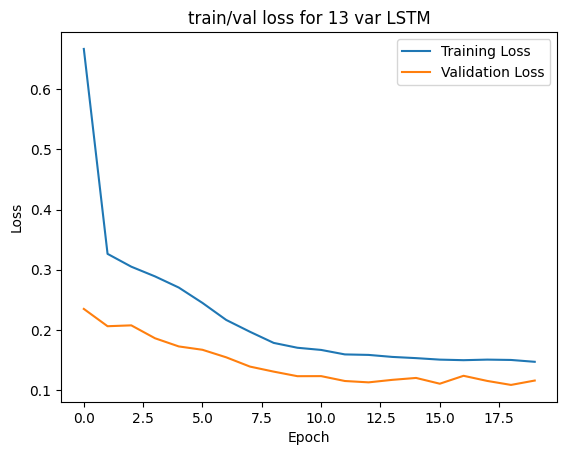

In [ ]:
display_train_val_loss(epoch_losses, val_losses, "train/val loss for 13 var LSTM")

6.08816676277533
1.977183687895894


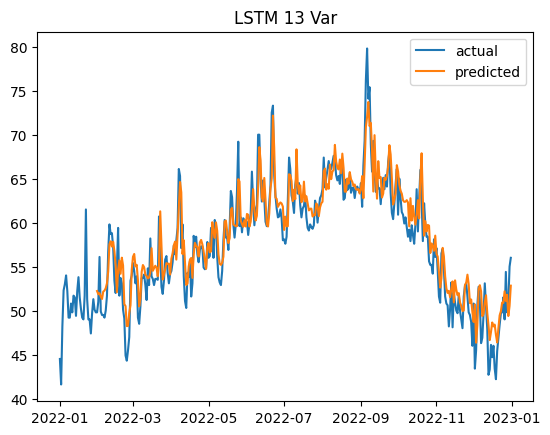

In [ ]:
test_model(model, dataloader_test, y_std, y_mean, "LSTM 13 Var")

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm_v1 = LSTMModel().to(device)
model_lstm_v13 = LSTMModel(input_dim=13).to(device)
model_cnn_lstm = CNN_LSTM().to(device)
model_blstm = BLSM().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"LSTM v1: {count_parameters(model_lstm_v1)}")
print(f"LSTM v13: {count_parameters(model_lstm_v13)}")
print(f"LSTM v13: {count_parameters(model_cnn_lstm)}")
print(f"LSTM v13: {count_parameters(model_blstm)}")

LSTM v1: 207489
LSTM v13: 213633
LSTM v13: 2072297
LSTM v13: 535047
